In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import json
import boto3

# Load map between attractions ids and names

In [2]:
raw_names = json.load(open('attractions_names_ids.json'))
attractions_names = {a.get('id'): a.get('name') for a in raw_names['activities']}
attractions_names

{'P1NA07': "'it's a small world'",
 'P1AA00': 'Adventure Isle',
 'P1NA00': "Alice's Curious Labyrinth",
 '00000': 'Alto secreto - En construcción: El nuevo cuartel general de Los Vengadores',
 'animationCelebration': 'Animation Celebration – Frozen : A Musical Invitation',
 'armageddon': 'Armageddon : les Effets Spéciaux',
 'artOfAnimation': 'Art of Disney Animation®',
 'P1DA03': 'Autopia',
 'P1RA00': 'Big Thunder Mountain',
 'P1NA01': 'Blanche-Neige et les Sept Nains®',
 'P1DA04': 'Buzz Lightyear Laser Blast',
 'P2XA02': 'Cars Quatre Roues Rallye',
 'P1NA03': 'Casey Jr. – le Petit Train du Cirque',
 'P2XA03': "Crush's Coaster",
 'P1MA00': 'Discovery Arcade',
 'P2FD03': 'Disney Studio 1',
 'P1MA01': 'Disneyland Railroad',
 'P1DA10': 'Disneyland Railroad Discoveryland Station',
 'P1NA16': 'Disneyland Railroad Fantasyland Station',
 'P1RA10': 'Disneyland Railroad Frontierland Depot',
 'P1MA05': 'Disneyland Railroad Main Street Station',
 'P1NA05': 'Dumbo the Flying Elephant',
 'P1RA07': 

# Load waiting times


In [12]:
#entity_id = 'P1NA10'
entities_ids = ['P1NA07', 'P1AA00', 'P1NA00', 'P1DA03']
#entities_ids = [k for k in attractions_names.keys() if 'P1' in k] # filter by P1

In [4]:
# Load from dumped json file

#items = json.load(open('../dynamodb/query_result.json'))
#df=pd.DataFrame(items['Items'])

In [5]:
# Load from dynamodb via boto3
client = boto3.client('dynamodb')

def fetch_data(entity_id):
    items = client.scan(
        ExpressionAttributeValues={
            ":id": {
                "S": entity_id
            }
        },
        FilterExpression='entity_id = :id',
        TableName='disneyland',
    )
    return items

In [6]:
def build_df(items):
    df = pd.DataFrame(items['Items'])
    df.posted_wait_minutes = df.posted_wait_minutes.astype('str').str.extract(r'\D*(?P<minutes>\d*)\D*').astype('int')
    df.response_timestamp = df.response_timestamp.astype('str').str.extract(r'\D*(?P<minutes>[0-9-:.+T]*)\D*')
    df=df.set_index('response_timestamp')
    df=df.sort_values(by=['response_timestamp'])
    #df.plot(y='posted_wait_minutes', title=attractions_names.get(entity_id))
    return df

P1NA07 'it's a small world'
P1AA00 Adventure Isle
P1NA00 Alice's Curious Labyrinth
P1DA03 Autopia


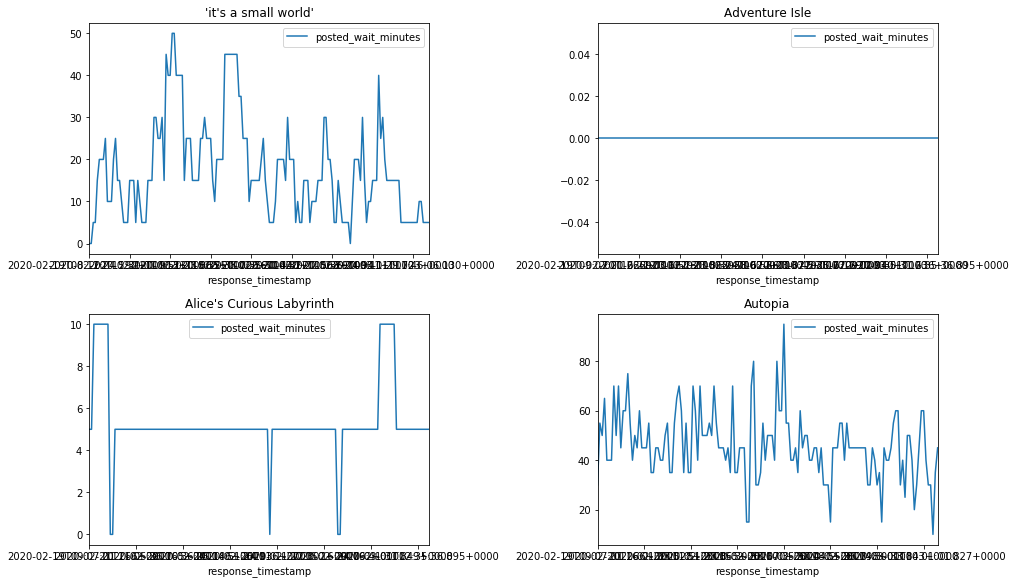

In [17]:
figsize = (14, 4*(len(entities_ids) // 2))
cols = 2
rows = (len(entities_ids)+1) // 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, constrained_layout=True)
row = col = 0

for entity_id in entities_ids:
    print(entity_id, attractions_names.get(entity_id))
    items = fetch_data(entity_id)
    df = build_df(items)
    df.plot(ax=axes[row,col], y='posted_wait_minutes', title=attractions_names.get(entity_id))
    row = row + col
    col = (col+1) % 2